<AxesSubplot:xlabel='date'>

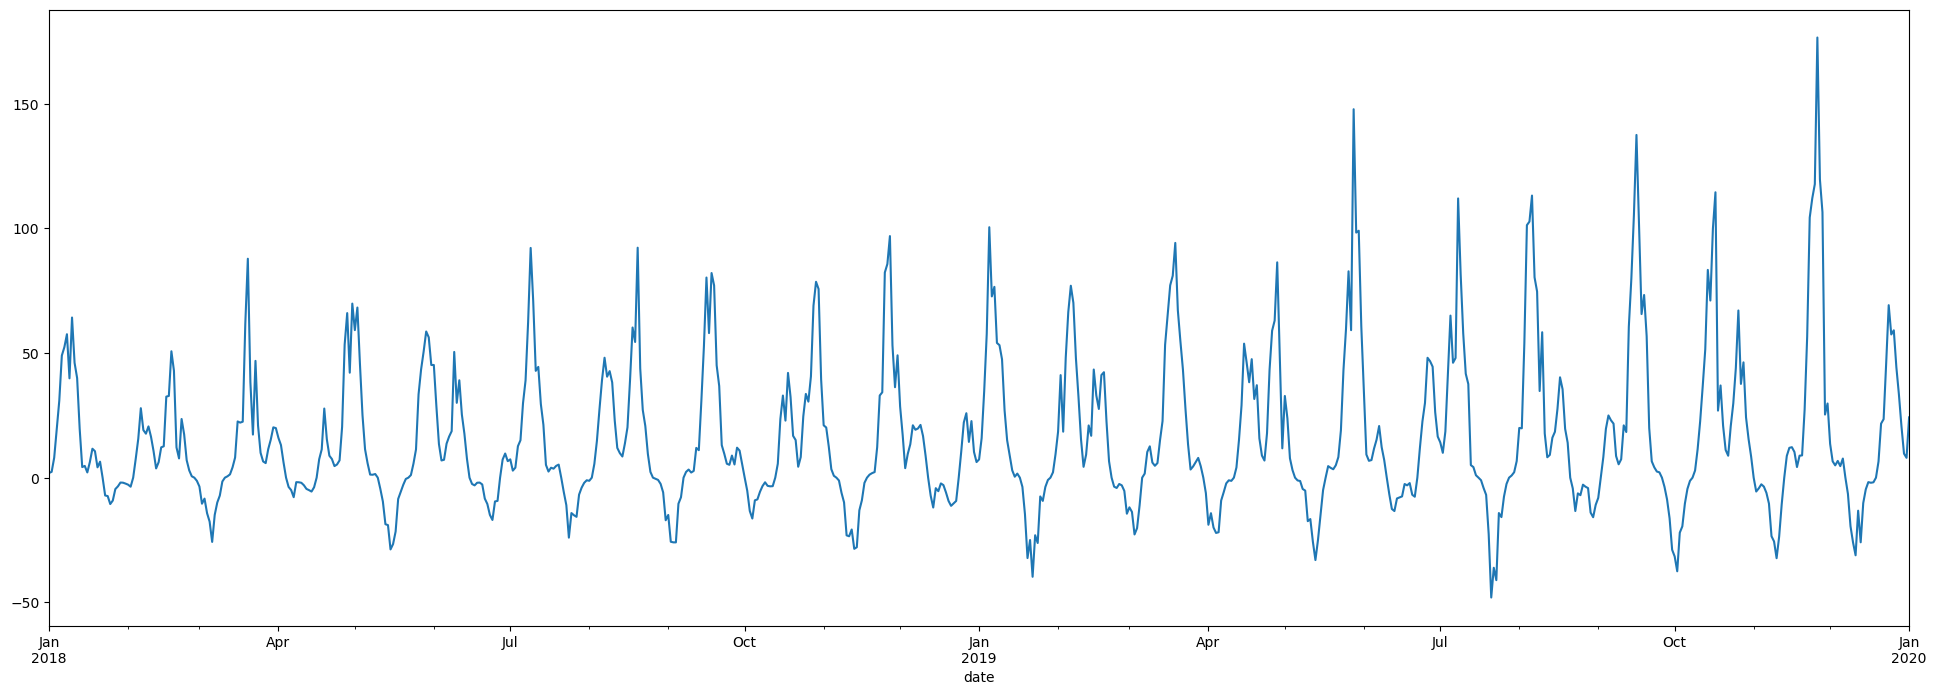

In [44]:
from timeseries_generator import LinearTrend, Generator, WhiteNoise, RandomFeatureFactor, HolidayFactor, SinusoidalFactor
from pandas._libs.tslibs.timestamps import Timestamp
import pandas as pd
import matplotlib.pyplot as plt

start_date = Timestamp("01-01-2018")
end_date = Timestamp("01-01-2020")

# setting up a linear tren
lt = LinearTrend(coef=2.0, offset=1., col_name="my_linear_trend")

# update by adding some white noise to the generator
wn = WhiteNoise(stdev_factor=.25)
holiday_factor = HolidayFactor(
    holiday_factor=2.,
    special_holiday_factors={
        "Christmas Day": 10.
    }
)
# holiday_factor.plot(start_date=start_date, end_date=end_date)

sf_1 = SinusoidalFactor(wavelength=36, amplitude=3.0, phase=0.0, mean=1.5, col_name="trend1")
sf_2 = SinusoidalFactor(wavelength=14, amplitude=3.0, phase=10.0, mean=3.5, col_name="trend2")
g = Generator(factors={lt, wn, sf_1, sf_2}, date_range=pd.date_range(start=start_date, end=end_date))
df = g.generate()
plot_df = df.set_index('date')
# plot_df.plot(figsize=(24,8))
plot_df["value"].plot(figsize=(24,8))

import matplotlib.pyplot as plt
def create_lagged_ts(df, lag=1, noise=WhiteNoise(stdev_factor=0.001)):
    new_df = df.copy()
    new_df["value"] = new_df["value"].shift(lag)
    # df = df.dropna()
    # df = df.reset_index(drop=True)
    # df = Generator.add_factor(df, noise)
    return new_df
df_2 = create_lagged_ts(df, lag=1)
plot_df_2 = df_2.set_index('date')
plt.figure()
plot_df["value"].plot(figsize=(24,8))
plot_df_2["value"].plot(figsize=(24,8))
plt.legend()

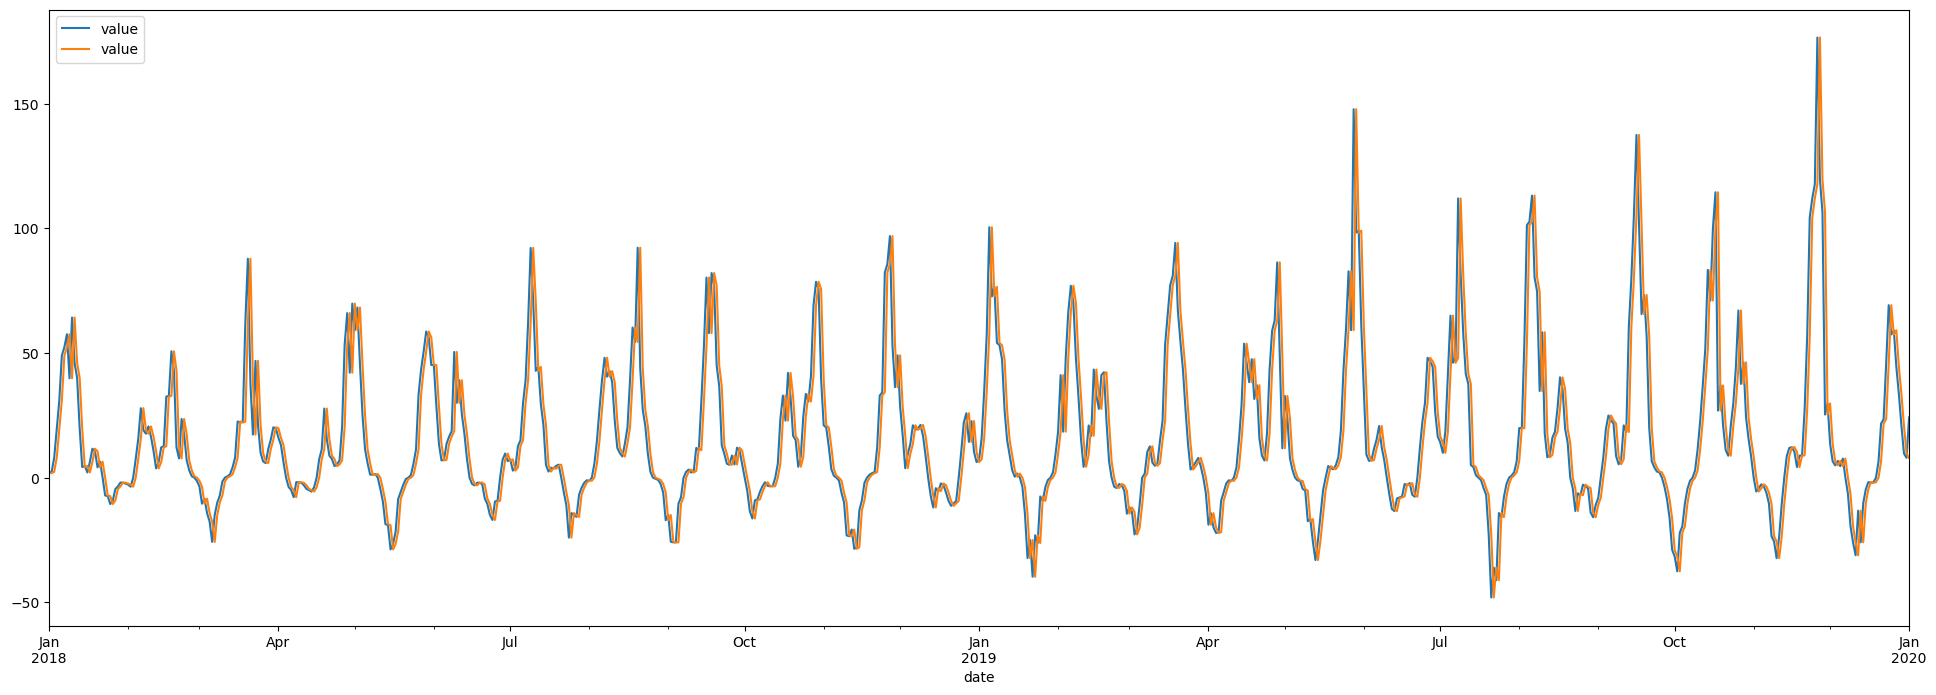

In [ ]:
def create_lagged_ts(df, lag=1, noise=WhiteNoise(stdev_factor=0.001)):
    new_df = df.copy()
    new_df["value"] = new_df["value"].shift(lag)
    # df = df.dropna()
    # df = df.reset_index(drop=True)
    # df = Generator.add_factor(df, noise)
    return new_df
df_2 = create_lagged_ts(df, lag=1)
plot_df_2 = df_2.set_index('date')
plt.figure()
plot_df["value"].plot(figsize=(24,8))
plot_df_2["value"].plot(figsize=(24,8))
plt.legend()

In [38]:
print(plot_df_2)

            base_amount    trend2  white_noise    trend1  my_linear_trend  \
date                                                                        
2018-01-01          1.0  0.575216     1.000438  1.500000         2.000000   
2018-01-02          1.0  0.575216     0.999626  2.020945         2.002736   
2018-01-03          1.0  1.154506     1.000911  2.526060         2.005472   
2018-01-04          1.0  2.198349     1.000539  3.000000         2.008208   
2018-01-05          1.0  3.500000     0.999290  3.428363         2.010944   
...                 ...       ...          ...       ...              ...   
2019-12-28          1.0  2.198349     1.000180  4.098076         3.986320   
2019-12-29          1.0  1.154506     0.999320  4.319078         3.989056   
2019-12-30          1.0  0.575216     0.999253  4.454423         3.991792   
2019-12-31          1.0  0.575216     1.000551  4.500000         3.994528   
2020-01-01          1.0  1.154506     0.999799  4.454423         3.997264   

## Generating multiple different time series and their lagged pendant 

In [1]:
import numpy as np
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt
from timeseries_generator import LinearTrend, Generator, WhiteNoise, SinusoidalFactor

def generate_multiple_time_series_with_lag_polars(
    start_date, end_date, num_series=5, lag=1,
    # linear_trend_params={"coef": (0.5, 5.0), "offset": (1.0, 3.0)},
    noise_range=(0.1, 1.0),
    sinusoidal_params={
        "wavelength": (10, 100),
        "amplitude": (1.0, 5.0),
        "phase": (0.0, 2 * np.pi),
        "mean": (0.0, 2.0)
    }
):
    # Initialize an empty polars DataFrame
    date_range = pd.date_range(start=start_date, end=end_date)
    pl_df = pl.DataFrame({"date": date_range})

    for i in range(num_series):
        # Randomly select parameters for noise
        noise_stdev = np.random.uniform(*noise_range)
        wn = WhiteNoise(stdev_factor=noise_stdev)

        # Randomly select parameters for sinusoidal factors
        sf_1 = SinusoidalFactor(
            wavelength=np.random.uniform(*sinusoidal_params["wavelength"]),
            amplitude=np.random.uniform(*sinusoidal_params["amplitude"]),
            phase=np.random.uniform(*sinusoidal_params["phase"]),
            mean=np.random.uniform(*sinusoidal_params["mean"]),
            col_name=f"trend1_{i}"
        )
        
        sf_2 = SinusoidalFactor(
            wavelength=np.random.uniform(*sinusoidal_params["wavelength"]),
            amplitude=np.random.uniform(*sinusoidal_params["amplitude"]),
            phase=np.random.uniform(*sinusoidal_params["phase"]),
            mean=np.random.uniform(*sinusoidal_params["mean"]),
            col_name=f"trend2_{i}"
        )

        # Set up a linear trend for context
        lt = LinearTrend(coef=2.0, offset=1.0, col_name=f"my_linear_trend_{i}")

        # Generate the time series
        g = Generator(factors={lt, wn, sf_1, sf_2}, date_range=date_range)
        df = g.generate()

        # Convert to polars DataFrame
        ts_pl_df = pl.DataFrame(df)
        # ts_pl_df[f"{i}_value_lagged"] = ts_pl_df.with_columns(ts_pl_df["value"].shift(lag))
        ts_pl_df = ts_pl_df.with_columns(ts_pl_df["value"].shift(lag).alias(f"{i}_value_lagged"))
        ts_pl_df = ts_pl_df.rename({"value": f"{i}_value"})


        
        # Merge the new time series into the main DataFrame
        pl_df = pl_df.join(ts_pl_df.select([f"{i}_value", f"{i}_value_lagged", "date"]), on="date", how="left")

    return pl_df

# Example usage
start_date = "2018-01-01"
end_date = "2020-01-01"
num_series = 5

time_series_df = generate_multiple_time_series_with_lag_polars(start_date, end_date, num_series=num_series, lag=1)
print(time_series_df)

shape: (731, 11)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ date      ┆ 0_value   ┆ 0_value_l ┆ 1_value   ┆ … ┆ 3_value   ┆ 3_value_l ┆ 4_value   ┆ 4_value_ │
│ ---       ┆ ---       ┆ agged     ┆ ---       ┆   ┆ ---       ┆ agged     ┆ ---       ┆ lagged   │
│ datetime[ ┆ f64       ┆ ---       ┆ f64       ┆   ┆ f64       ┆ ---       ┆ f64       ┆ ---      │
│ ns]       ┆           ┆ f64       ┆           ┆   ┆           ┆ f64       ┆           ┆ f64      │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ 2018-01-0 ┆ 9.546615  ┆ null      ┆ 3.915154  ┆ … ┆ 9.882997  ┆ null      ┆ 31.751298 ┆ null     │
│ 1         ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 00:00:00  ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 2018-01-0 ┆ 3.407876  ┆ 9.546615  ┆ 7.591468  ┆ … ┆ 11.167952 ┆ 9.882997

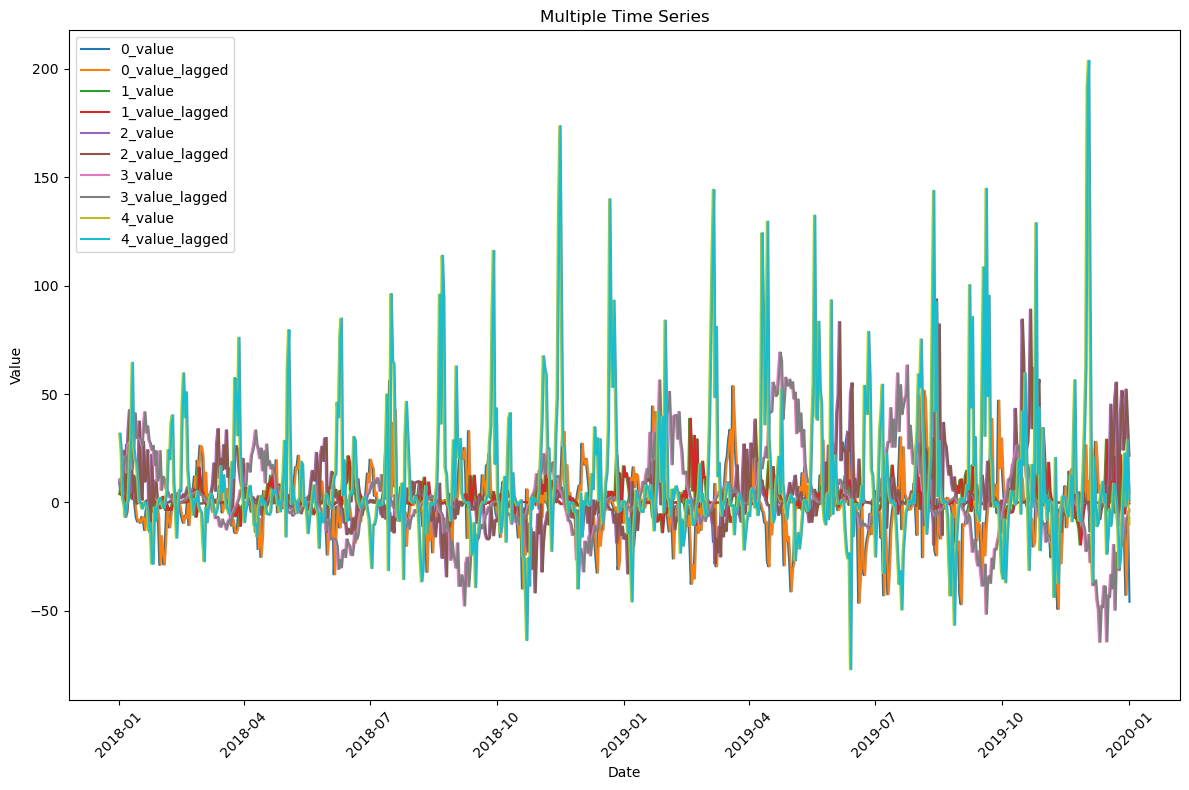

In [2]:
# PLOT ALL IN ONE PLOT

df_pandas = time_series_df.to_pandas()

# Plotting all the time series in one plot
plt.figure(figsize=(12, 8))

# Loop through all columns except the 'date' column
for col in df_pandas.columns:
    if col != "date":  # Avoid plotting the date column
        plt.plot(df_pandas['date'], df_pandas[col], label=col)

# Add a legend to identify each time series
plt.legend()

# Add labels and title
plt.xlabel("Date")
plt.ylabel("Value")
plt.title("Multiple Time Series")

# Show the plot
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

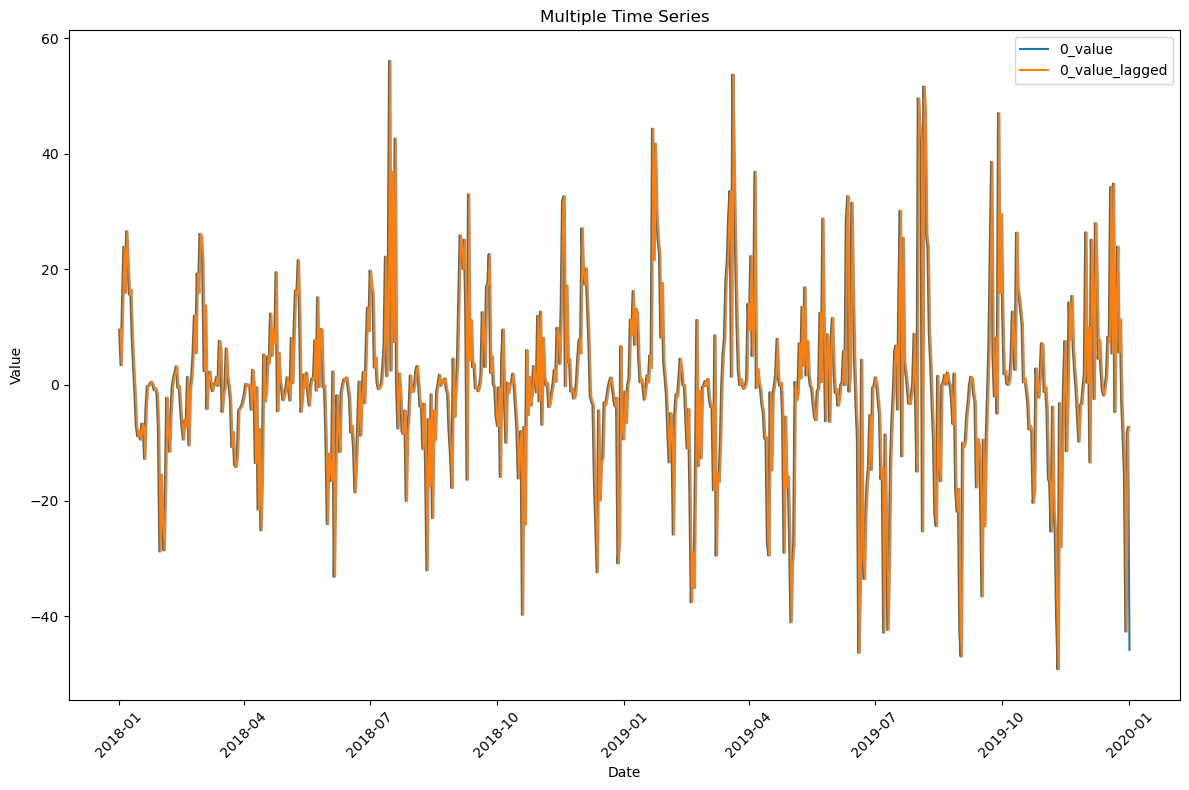

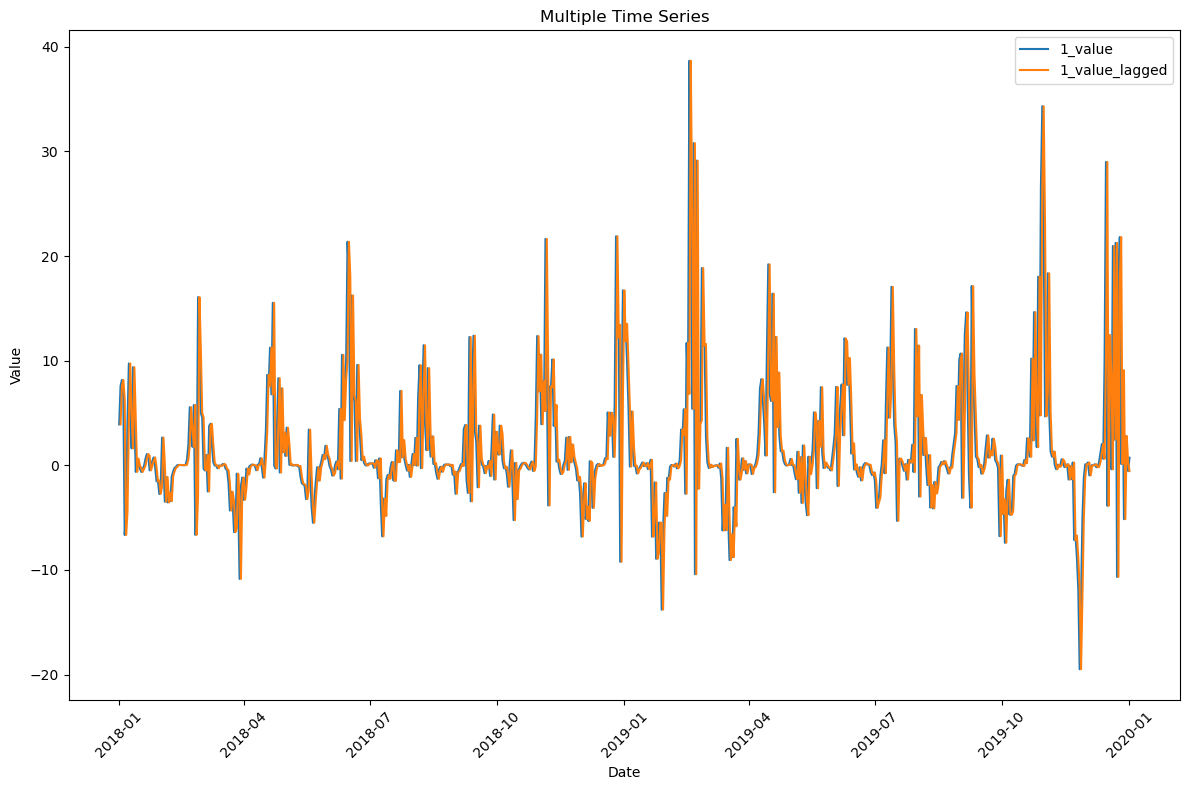

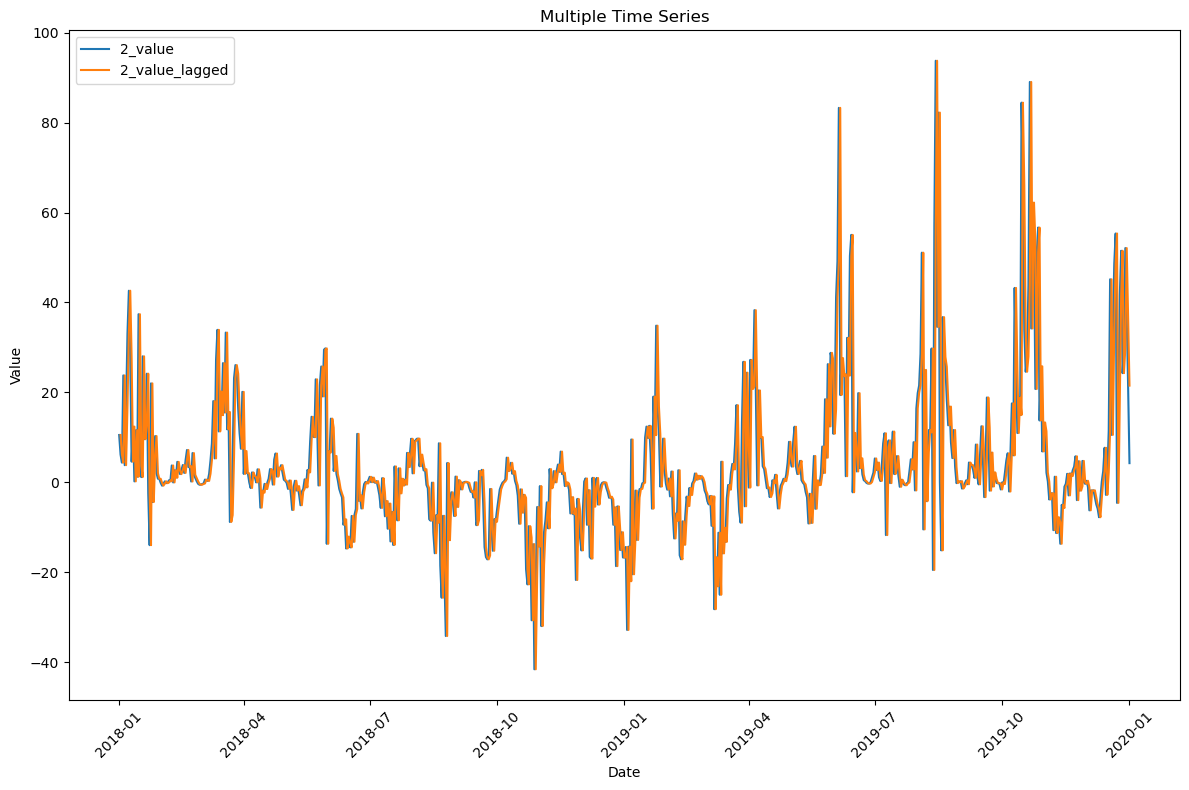

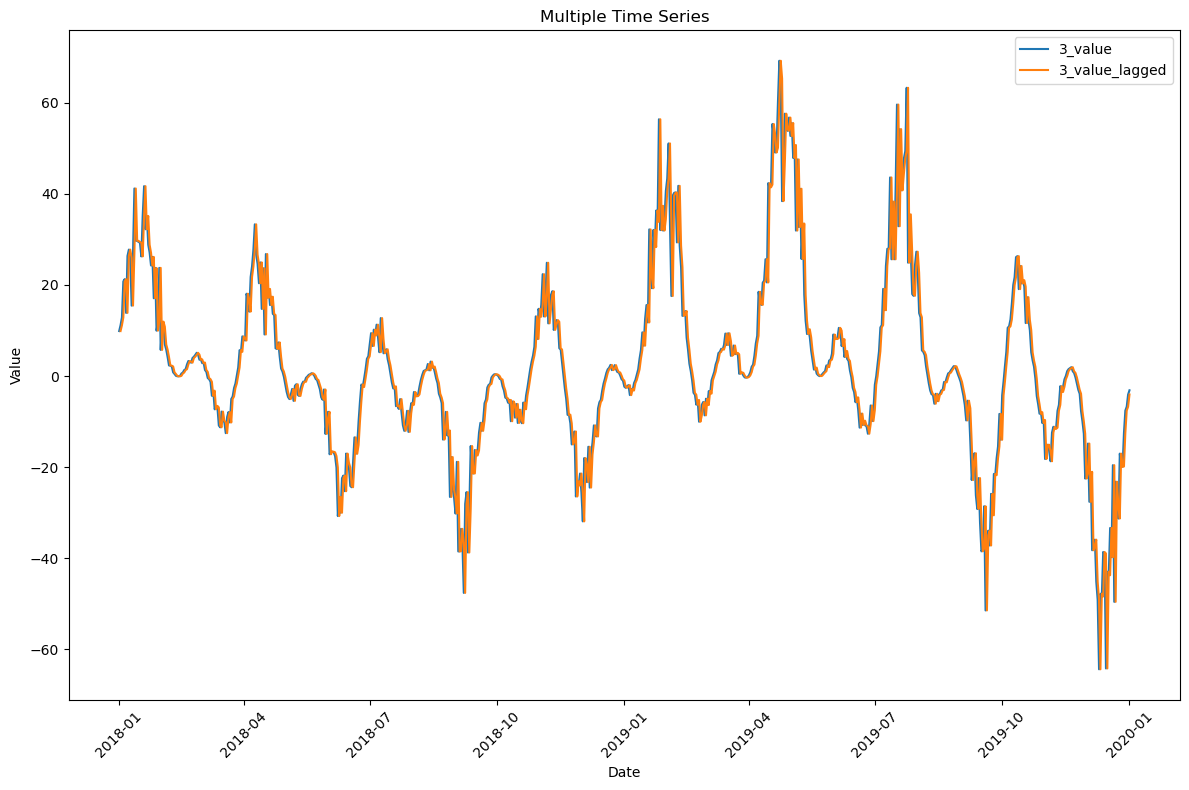

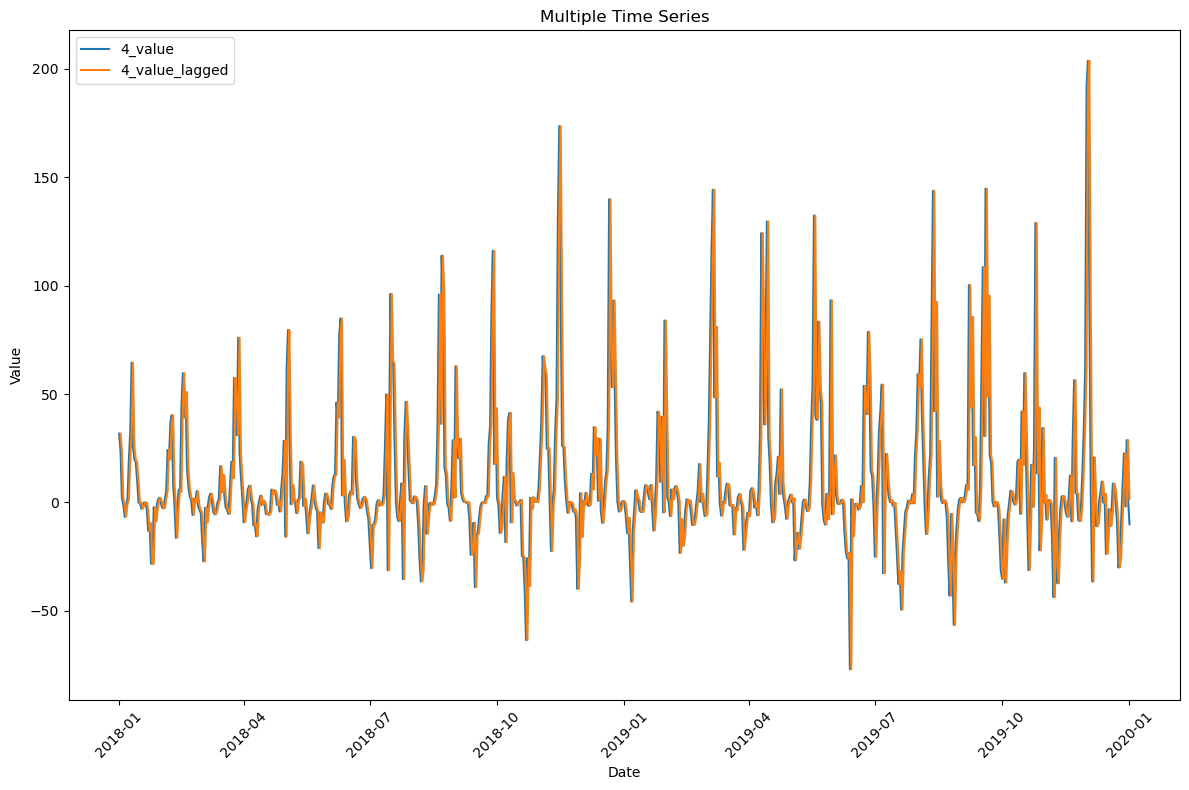

In [3]:
# PLOT EACH 2 TIME SERIES IN A SEPARATE PLOT
df_pandas = time_series_df.to_pandas()

for i in range(num_series):
    # Plotting all the time series in one plot
    plt.figure(figsize=(12, 8))
    plt.plot(df_pandas['date'], df_pandas[f"{i}_value"], label=f"{i}_value")
    plt.plot(df_pandas['date'], df_pandas[f"{i}_value_lagged"], label=f"{i}_value_lagged")

    # Add a legend to identify each time series
    plt.legend()

    # Add labels and title
    plt.xlabel("Date")
    plt.ylabel("Value")
    plt.title("Multiple Time Series")

    # Show the plot
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()